# 1. Imports

In [19]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import sys
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
#import onnx
#import onnxruntime as ort
from PIL import Image
import torchvision.transforms as transforms
import numpy as np


base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(base_dir)

sys.path.append(base_dir)

%matplotlib inline

c:\ProjetosPython\PICOS


# 2. Funcoes

In [205]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

class CustomTransform: # Transformação das imagens
    def __call__(self, img, target):
        if isinstance(img, torch.Tensor):
            return img.to(device), target  # Verifica se a imagem é tensor, caso seja já envia para o dispositivo

        img = transforms.ToTensor()(img)  # Caso não seja Tensor, transforma em tensor
        return img.to(device), target  # Envia a imagem para o dispositivo
    
class CustomDataset(CocoDetection): # Configuração do dataset personalizado
    def __init__(self, root, annotation, transforms=None):
        super().__init__(root, annotation)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)

        if self.transforms:
            img, target = self.transforms(img, target)  # Aplica a transformação na imagem e no target

        return img, target

def load_settings():
    """Função para ler as configurações de um arquivo .txt e atribuir os valores diretamente às variáveis."""
    # Valores padrão
    defaults = {
        'perc_top': 0.4,
        'perc_bottom': 0.8,
        'min_score': 0.5,
        'limit_center': 8,
        'save_dir': 'data\\outputs\\capturas',
        'square_size': 640,
        'grid_x': 0,
        'grid_y': 0,
        'crop_image': 1  # 1 = Sim
    }

    return (
        defaults['perc_top'],
        defaults['perc_bottom'],
        defaults['min_score'],
        defaults['limit_center'],
        defaults['save_dir'],
        defaults['square_size'],
        defaults['grid_x'],
        defaults['grid_y'],
        defaults['crop_image'],
    )

def select_image(images_dir, image_choice, annotations_path=None):
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    image_path = None
    image_file = None
    annotations = None

    if annotations_path:
        with open(os.path.join(base_dir, annotations_path)) as f:
            coco_data = json.load(f)

        # Filtrar apenas imagens .jpg no COCO
        image_files = [
            image for image in coco_data['images']
            if image['file_name'].lower().endswith('.jpg')
        ]

        # Criar dicionário de anotações
        annotations_dict = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations_dict:
                annotations_dict[image_id] = []
            annotations_dict[image_id].append(annotation)

        if 0 <= image_choice < len(valid_images):
            image_info = valid_images[image_choice]
            image_file = image_info['file_name']
            image_path = os.path.join(base_dir, images_dir, image_file)
            image_id = image_info['id']
            annotations = annotations_dict.get(image_id, [])
    else:
        # Carregar apenas arquivos .jpg da pasta
        image_files = sorted([
            f for f in os.listdir(os.path.join(base_dir, images_dir))
            if f.lower().endswith('.jpg')
        ])
        if 0 <= image_choice < len(image_files):
            image_file = image_files[image_choice]
            image_path = os.path.join(base_dir, images_dir, image_file)
            annotations = None

    return image_path, annotations, image_file
    
def visualize_coco_all_annotations(image_path, annotations, image_name):
    # Carregar a imagem original
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converter para RGB para exibição com matplotlib
    
    # Criar uma cópia para desenhar anotações
    annotated_image = image_rgb.copy()
    
    # Exibir informações da imagem
    height, width, channels = image.shape
    print(f"Exibindo imagem: {image_name}")
    print(f"Dimensões da imagem: {width}x{height} (largura x altura, {channels} canais)")

    # Desenhar as bounding boxes na imagem anotada
    for annotation in annotations:
        x, y, w, h = annotation['bbox']
        cv2.rectangle(annotated_image, (int(x), int(y)), (int(x + w), int(y + h)), color=(255, 0, 0), thickness=2)
        print(f"Coordenadas da bounding box: x={x}, y={y}, width={w}, height={h}")
    
    # Criar uma figura com 2 subplots: imagem original e anotada
    plt.figure(figsize=(16, 8))

    # Subplot 1: imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Imagem Original")
    plt.axis('off')

    # Subplot 2: imagem com anotações
    plt.subplot(1, 2, 2)
    plt.imshow(annotated_image)
    plt.title(f"Imagem com anotações: {len(annotations)} detecções")
    plt.axis('off')

    plt.show()

def create_model(weights, num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model

def load_pretrained_model(device, model, pretrained_model_path):
    if pretrained_model_path and os.path.exists(pretrained_model_path):
        model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print(f"Modelo carregado de: {pretrained_model_path}")

    else:
        print("Treinando modelo do zero...")

    model.to(device)
    return model

def load_model_eval(device, model, pretrained_model_path):  # Colocar o modelo em modo de avaliação
    model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
    model.to(device)
    model.eval() 
    
    return model

def run_model(torch_device, type_model, model, frame):
    if type_model == 'YOLO':
        results = model(frame)  # Realizar a detecção com o YOLO, sem marcações antes, imagem pura
        detections = results[0].boxes  # Obter as detecções

        # Extrair boxes e scores em um único loop
        detections_info = [(detection.xyxy[0].tolist(), float(detection.conf)) for detection in detections]
        
        boxes, scores = (zip(*detections_info) if detections_info else ([], []))  # Separar os boxes e scores em variáveis distintas

        detections = []  # Cria uma lista para armazenar as detecções

        # Itera sobre as caixas e pontuações para criar pares (box, score)
        for box, score in zip(boxes, scores):
            detections.append([box, score])  # Não é necessário usar box.tolist() aqui

        # Ordena as detecções pelo valor de x_min
        detections_sorted = sorted(detections, key=lambda det: det[0][0])  # Ordena pelo x_min

    if type_model in ['FRCNN_RN50', 'FRCNN_MNV3L', 'FRCNN_MNV3S']:
        # Pré-processar a imagem
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
        transform = (transforms.ToTensor())  # Define a transformação para ToTensor
        image_tensor = (transform(image).unsqueeze(0).to(torch_device))  # Converte a imagem para tensor e adiciona uma dimensão de batch

        # Aplicar o modelo na imagem
        with torch.no_grad():  # Desativar cálculo de gradientes para economizar memória
            predictions = model(image_tensor)  # Fazer previsões

        boxes = (predictions[0]['boxes'].cpu().detach().numpy())   # Converte as previsões para arrays do numpy
        scores = (predictions[0]['scores'].cpu().detach().numpy())   # Converte as previsões para arrays do numpy

        detections = []   # Cria uma lista para armazenar as detecções

        # Itera sobre as caixas e pontuações para criar pares (box, score)
        for box, score in zip(boxes, scores):
            detections.append([box.tolist(), float(score)])

        # Obter as detecções
        detections_sorted = sorted(detections, key=lambda deteccao: deteccao[0][0])   # Ordena pelo x_min

    return detections_sorted

def dataset_config(images_dir, annotations_path, data_loader_batch_size):
    dataset = CustomDataset(
        root=os.path.join(base_dir, images_dir),
        annotation=os.path.join(base_dir, annotations_path),
        transforms=CustomTransform()  # Passa a transformação customizada
    )

    # Configuração do DataLoader
    data_loader = DataLoader(dataset, batch_size=data_loader_batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    return dataset, data_loader

def load_image_tensor(image_path):
    image = Image.open(image_path).convert("RGB")  # Carrega a imagem e converte para RGB
    transform = transforms.ToTensor()  # Define a transformação para ToTensor
    image_tensor = transform(image).unsqueeze(0)  # Converte a imagem para tensor e adiciona uma dimensão de batch
    
    return image_tensor

def rules_detection(frame, detections_sorted, perc_top, perc_bottom, perc_median, min_score, limit_center):
    def median_calculate(detections_sorted, min_score, height, perc_median):
        all_centers = ([])  # Lista para armazenar as coordenadas y dos centros detectados
        for idx, detection in enumerate(detections_sorted):
            score = detection[1]   # Pontuação de confiança
            x_min, y_min, x_max, y_max = detection[0]  # Coordenadas da caixa - y cresce de cima para baixo

            # Verificar se a pontuação é maior que o limite e se está entre as linhas de contagem
            if (score > min_score and y_max > line_limit_top and y_min < line_limit_bottom):
                center_y = (y_min + y_max) // 2   # Calcular o centro da caixa de detecção
                all_centers.append(center_y)  # Adiciona y à lista de centros

                if all_centers:
                    median_y = int(np.median(all_centers))  # Obtém a mediana
                    line_bottom_median = int(median_y + int((height * perc_median) / 2))
                    line_top_median = int(median_y - int((height * perc_median) / 2))
                    
                    cv2.line(
                        frame, 
                        (640, median_y), 
                        (640 + 640, median_y), 
                        (255, 0, 0), 
                        2,
                    )  # Desenhar a linha horizontal na moda

        return all_centers, median_y, line_top_median, line_bottom_median

    def filtrar_deteccoes(detections_sorted, centers, median_y, line_limit_top, line_limit_bottom, 
                      line_top_median, line_bottom_median, min_score, limit_center):
        """Filtra as detecções válidas com base em múltiplas condições."""
        valid_centers = []

        if centers and line_limit_bottom > median_y > line_limit_top:
            for idx, detection in enumerate(detections_sorted):
                score = detection[1]
                x_min, y_min, x_max, y_max = detection[0]

                center_x = int((x_min + x_max) // 2)
                center_y = int((y_min + y_max) // 2)
                area = (x_max - x_min) * (y_max - y_min)

                test_score = score > min_score
                test_center = not any(np.linalg.norm(np.array([center_x, center_y]) - np.array(center)) < limit_center for center in valid_centers)
                test_center_x = not any(abs(center_x - center[0]) < limit_center for center in valid_centers) # Redundante
                test_median = (y_max > line_top_median and y_min < line_bottom_median)
                test_area = area >= 2000  # Area precisa ser maior que x (excluir pedacos soltos)

                if test_score and test_median and test_center and test_area:
                        valid_centers.append((center_x, center_y))

        return valid_centers

    def marcar_deteccoes(frame, valid_detections, limit_center):
        """Desenha as detecções válidas no frame e atualiza o total."""
        total_detections = 0  # Contador total de detecções
        for center_x, center_y in valid_detections:
            total_detections += 1

            cv2.circle(frame, (center_x, center_y), limit_center - 1, (0, 0, 255), -1)
            cv2.circle(frame, (center_x, center_y), limit_center, (255, 0, 0), 1)
            cv2.putText(frame, str(total_detections), (center_x - 6, center_y + 3),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1)

        return total_detections

    height, width = frame.shape[:2]

    # Define as posições das linhas
    line_limit_top = int(height * perc_top)    # Só conta quando a mediana entrar nesse range
    line_limit_bottom = int(height * perc_bottom)   # Só conta quando a mediana entrar nesse range
    dif_limit = line_limit_bottom - line_limit_top

    line_top_median = None  # É calculada a mediana das detecções, e só são contados biscoitos que estão naquela mediana + - um valor de range
    line_bottom_median = None   # É calculada a mediana das detecções, e só são contados biscoitos que estão naquela mediana + - um valor de range

    ### CALCULO DA MEDIANA
    all_centers, median_y, line_top_median, line_bottom_median = median_calculate(detections_sorted, min_score, height, perc_median)

    ### FILTRAGEM
    valid_centers = filtrar_deteccoes(detections_sorted, all_centers, median_y, line_limit_top, line_limit_bottom, line_top_median, line_bottom_median, min_score, limit_center)

    ### MARCACAO
    total_detections = marcar_deteccoes(frame, valid_centers, limit_center)

    cv2.rectangle(frame, (0, 0), (frame.shape[1], 40), (80, 43, 30), -1)

    cv2.line(frame, (0, line_top_median), (640 + 640, line_top_median), (255, 0, 0), 2)
    cv2.line(frame,(0, line_bottom_median), (640 + 640, line_bottom_median), (255, 0, 0), 2)

    text_position = (0, 0)
    text = f'Total de Biscoitos: {total_detections}'
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
    text_x = 10  # margem esquerda
    text_y = int((40 + text_height) / 2)  # centralizado verticalmente
    
    cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

    return frame, total_detections

def no_rules_detection(frame, detections_sorted, perc_top, perc_bottom, min_score, limit_center):
    total_detections = 0  # Contador total de detecções

    for idx, detection in enumerate(detections_sorted):
        score = detection[1]
        x_min, y_min, x_max, y_max = detection[0]

        center_x = int((x_min + x_max) // 2)
        center_y = int((y_min + y_max) // 2)

        total_detections += 1

        # Marca o centro com um círculo vermelho
        cv2.circle(
            frame,
            (center_x, center_y),
            7,
            (0, 0, 255),
            -1,
        )

        # Círculo azul indicando o raio que antes era o limit_center
        cv2.circle(
            frame,
            (center_x, center_y),
            limit_center,
            (255, 0, 0),
            1,
        )

        # Número da detecção
        cv2.putText(
            frame,
            str(total_detections),
            (center_x - 6, center_y + 3),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.35,
            (255, 255, 255),
            1,
        )

    # Área superior de fundo do texto
    cv2.rectangle(
        frame,
        (0, 0),
        (frame.shape[1], 40),
        (80, 43, 30),
        -1,
    )

    # Texto de total
    text = f'Total de Biscoitos: {total_detections}'
    cv2.putText(
        frame,
        text,
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (255, 255, 255),
        2,
    )

    return frame, total_detections

def visualize_predictions_image(print_images, device, model, image_path, coco_annotations=None, anotacoes_txt_path=None, threshold=0.5, limit_center = 6, perc_median = 0.35, perc_top = 0.35, perc_bottom = 0.6):
    # Tratamento inicial das imagens
    image_tensor = load_image_tensor(image_path)
    image_np = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    image_detected = (image_np * 255).astype(np.uint8).copy()  # OpenCV usa 0-255
    image_annotated = image_np.copy()

    frame_bgr = cv2.cvtColor(image_detected, cv2.COLOR_RGB2BGR)

    # Regras nas anotacoes
    height, width = frame_bgr.shape[:2]
    line_limit_top = int(height * perc_top)    # Só conta quando a mediana entrar nesse range
    line_limit_bottom = int(height * perc_bottom)   # Só conta quando a mediana entrar nesse range

    qtd_annotations_rules = 0
    # ---------- Regras nas anotações COCO ----------
    coco_annotations_rules = []
    if coco_annotations:
        for ann in coco_annotations:
            x, y, w, h = ann['bbox']
            y_min = y
            y_max = y + h

            # Filtrar somente as anotações dentro da faixa de interesse
            if y_max > line_limit_top and y_min < line_limit_bottom:
                coco_annotations_rules.append(ann)
        qtd_annotations_rules = len(annotations_rules)

    # ---------- Contagem de anotações reais via nome ----------
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    if image_name and anotacoes_txt_path:
        try:
            with open(anotacoes_txt_path, 'r') as f:
                for line in f:
                    line = line.strip()
                    if line.startswith(image_name):
                        # Pega o número após o último "_"
                        qtd_annotations_rules = int(line.split('_')[-1])
                        break
        except Exception as e:
            print(f"[Erro] Falha ao ler arquivo de anotações: {e}")

    # Regras na deteccao
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        predictions = model(image_tensor)

    prediction = predictions[0]

    boxes_pred = prediction['boxes'].cpu().detach().numpy()
    scores_pred = prediction['scores'].cpu().detach().numpy()

    detections = []   # Cria uma lista para armazenar as detecções

    # Itera sobre as caixas e pontuações para criar pares (box, score)
    for box, score in zip(boxes_pred, scores_pred):
        detections.append([box.tolist(), float(score)])

    # Obter as detecções
    detections_sorted = sorted(detections, key=lambda deteccao: deteccao[0][0])   # Ordena pelo x_min

    # Aplicar regras na imagem de detecção (OpenCV)
    frame_bgr, total_detections = rules_detection(
        frame=frame_bgr,
        detections_sorted=detections_sorted,
        perc_top=perc_top,
        perc_bottom=perc_bottom,
        perc_median=perc_median,
        min_score=threshold,
        limit_center=limit_center,
    )

    print(f"Anotacoes: {qtd_annotations_rules} / Deteccoes: {total_detections}")
    # Criar subplots
    if print_images == True:
        fig, ax = plt.subplots(1, 3, figsize=(24, 8))

        # Imprimir Imagem Original
        ax[0].imshow(image_np)
        ax[0].axis('off')
        ax[0].set_title('Imagem Original', fontsize=16)

        # Imprimir Imagem com Anotações
        ax[1].imshow(image_annotated)
        
        # Linha de limite superior
        ax[1].axhline(y=line_limit_top, color='green', linewidth=2)

        # Linha de limite inferior
        ax[1].axhline(y=line_limit_bottom, color='green', linewidth=2)

        ax[1].set_title(f'Imagem com Anotações: {qtd_annotations_rules}', fontsize=16)

        ax[1].axis('off')

        if coco_annotations:
            for ann in coco_annotations:
                x, y, w, h = ann['bbox']
                y_min = y
                y_max = y + h

                # Filtrar somente as anotações dentro da faixa de interesse
                if y_max > line_limit_top and y_min < line_limit_bottom:
                    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='blue', facecolor='none')
                    ax[1].add_patch(rect)

        # Imprimir Imagem com Detecções
        image_detected = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        ax[2].imshow(image_detected)
        ax[2].axis('off')
        ax[2].set_title(f'Imagem com Detecções Regradas: {total_detections}', fontsize=16)


        plt.tight_layout()
        plt.show()
    
    result = qtd_annotations_rules == total_detections
    return result


In [206]:
###################################### Modelo ######################################
# Iniciar
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Definir o dispositivo (GPU ou CPU)

# Inputs
save_dir = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
models_path = os.path.join(base_dir, 'data', 'inputs', 'ia_models', 'FRCNN Resnet50')
pretrained_model_path = os.path.join(models_path, 'best_faster_rcnn_model_20250604_111351.pth')  # Altere para o caminho do modelo salvo (ex: 'caminho/para/modelo.pth') ou mantenha None para treinar do zero
weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1'
num_classes = 2  # Inclua o número de classes (background + classes)
num_epochs = 10000
data_loader_batch_size = 1

model = create_model(weights, num_classes)
model = load_pretrained_model(device, model, pretrained_model_path)
model = load_model_eval(device, model, pretrained_model_path)

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_24632\1429826798.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pretrained_model_path, 

Modelo carregado de: c:\ProjetosPython\PICOS\data\inputs\ia_models\FRCNN Resnet50\best_faster_rcnn_model_20250604_111351.pth


# 3. Individual

c:\ProjetosPython\PICOS\data\outputs\capturas_video2\SM\SM_14__20250608_195837.jpg
Modelo no modo de avaliação no dispositivo: cuda:0
Anotacoes: 24 / Deteccoes: 24


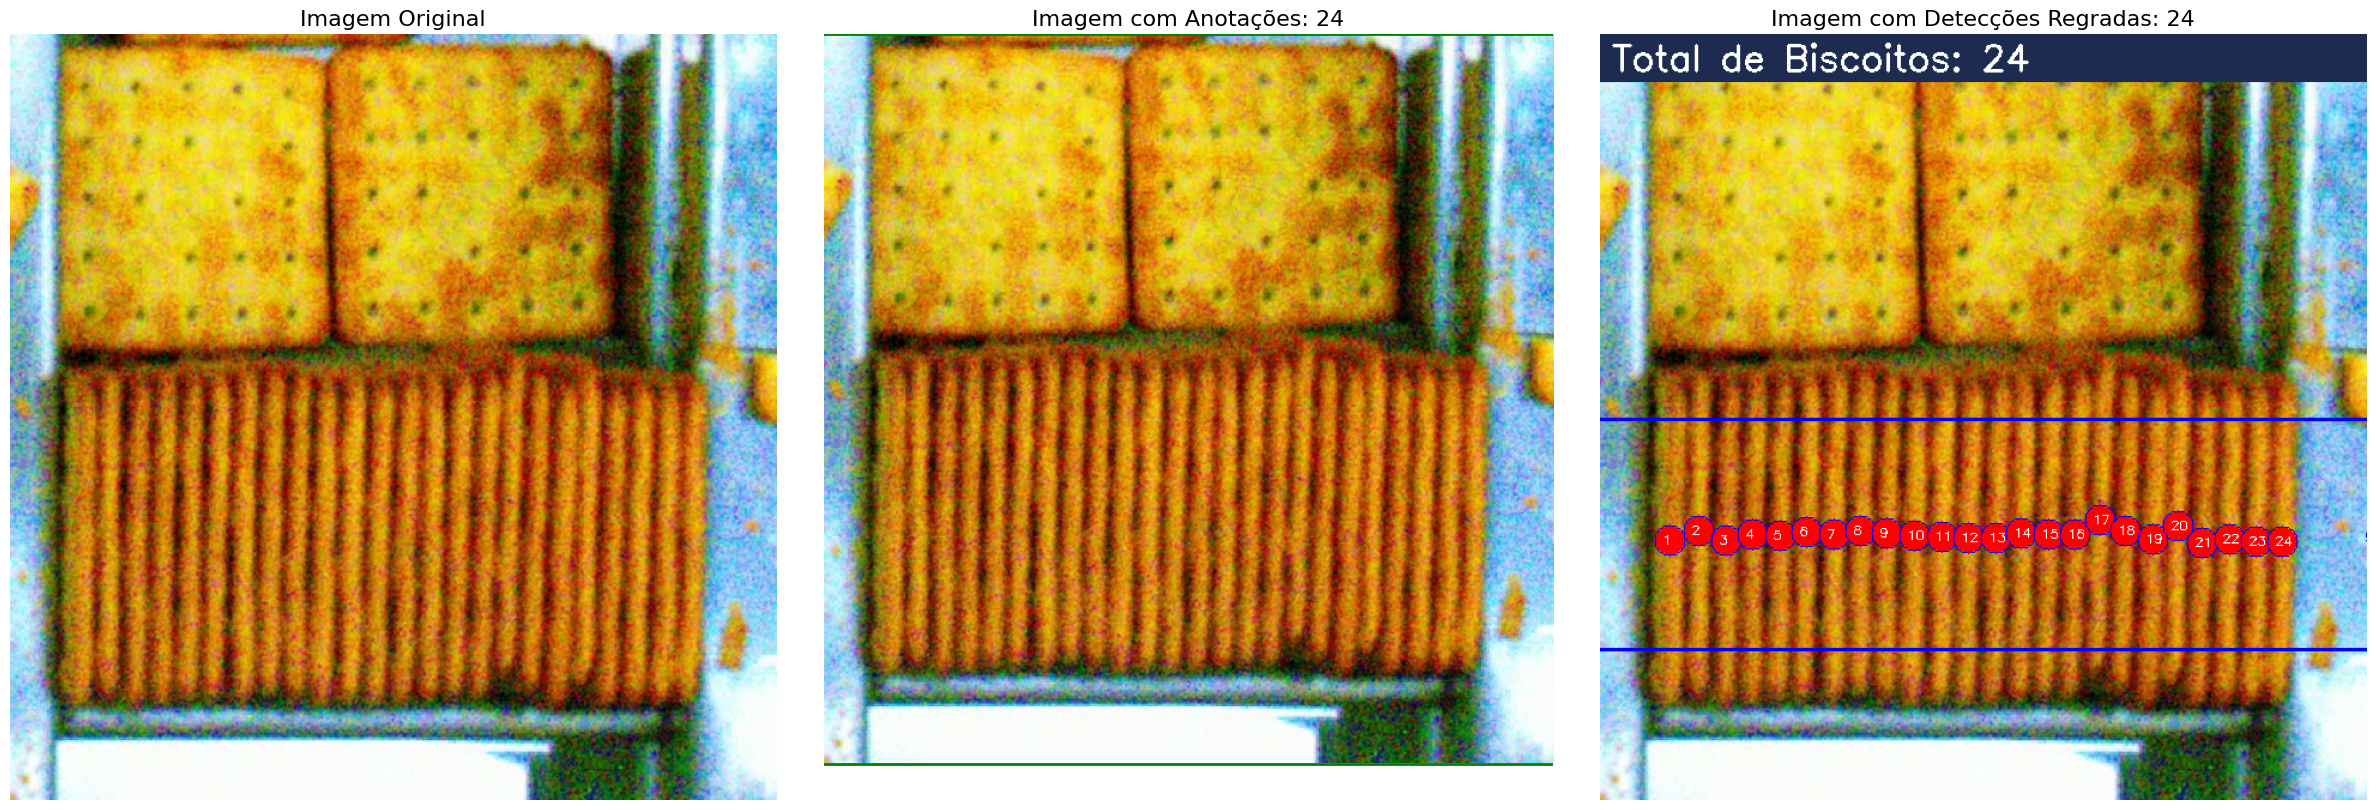

True


In [208]:
images_dir = r'data\outputs\capturas_video2\SM'  
annotations_path = None  
image_choice = 137 # Escolher a imagem (ajuste conforme necessário)

image_path, annotations, image_file = select_image(images_dir, image_choice, annotations_path)
anotacoes_txt_path= r'C:\ProjetosPython\PICOS\data\outputs\capturas_video2\analise_teste.txt'

print(image_path)

print(f"Modelo no modo de avaliação no dispositivo: {next(model.parameters()).device}") # Verificar se o modelo está no dispositivo correto (GPU ou CPU)

result = visualize_predictions_image(True, device, model, image_path, annotations, anotacoes_txt_path=anotacoes_txt_path, threshold=0.3, perc_top=0, perc_bottom=1, perc_median = 0.3, limit_center = 13)
print(result)
######################################################################################


# 4 Check Geral

In [153]:
import glob

caminho = r'C:\ProjetosPython\PICOS\data\outputs\capturas\SM\*.jpg'
arquivos_jpeg = glob.glob(caminho)

# Apenas os nomes dos arquivos (sem o caminho)
nomes_arquivos = [arq.split('\\')[-1] for arq in arquivos_jpeg]

for arquivo in nomes_arquivos:
    print(arquivo.replace('_CM', '').replace('.jpg', ''))

SM_14__20250608_195613
SM_14__20250608_195614
SM_14__20250608_195615
SM_14__20250608_195616
SM_14__20250608_195617
SM_14__20250608_195618
SM_14__20250608_195619
SM_14__20250608_195620
SM_14__20250608_195621
SM_14__20250608_195622
SM_14__20250608_195623
SM_14__20250608_195624
SM_14__20250608_195625
SM_14__20250608_195626
SM_14__20250608_195627
SM_14__20250608_195628
SM_14__20250608_195629
SM_14__20250608_195630
SM_14__20250608_195631
SM_14__20250608_195632
SM_14__20250608_195633
SM_14__20250608_195634
SM_14__20250608_195635
SM_14__20250608_195636
SM_14__20250608_195637
SM_14__20250608_195638
SM_14__20250608_195639
SM_14__20250608_195640
SM_14__20250608_195641
SM_14__20250608_195642
SM_14__20250608_195643
SM_14__20250608_195644
SM_14__20250608_195645
SM_14__20250608_195646
SM_14__20250608_195647
SM_14__20250608_195648
SM_14__20250608_195649
SM_14__20250608_195650
SM_14__20250608_195651
SM_14__20250608_195652
SM_14__20250608_195653
SM_14__20250608_195654
SM_14__20250608_195655
SM_14__2025

In [209]:
def check_geral( perc_median, threshold, limit_center, print_images = False):
    base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
    images_dir = r'data\outputs\capturas_video1\SM'  
    annotations_path = None
    anotacoes_txt_path= r'C:\ProjetosPython\PICOS\data\outputs\capturas_video1\analise_teste.txt'

    image_files = sorted([
        f for f in os.listdir(os.path.join(base_dir, images_dir))
        if f.lower().endswith('.jpg')
    ])

    num_images = len(image_files)

    list_correct = []
    list_incorrect = []
    for image_choice in range(0, num_images):
            image_path, annotations, image_file = select_image(images_dir, image_choice, annotations_path)

            result = visualize_predictions_image(print_images, device, model, image_path, annotations, anotacoes_txt_path=anotacoes_txt_path, perc_median = perc_median, threshold=threshold, limit_center=limit_center, perc_top=0, perc_bottom=1)

            if result == True:
                list_correct.append(image_path)
                print(f"✅ Correto (C:{len(list_correct)} | I:{len(list_incorrect)}) ({len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%):  {image_path}")


            else: 
                list_incorrect.append(image_path)
                print(f"❌ Incorreto (C:{len(list_correct)} | I:{len(list_incorrect)}) ({len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%):  {image_path}")

    print('--------------------------------------------------------------------------------------')
    print(f' Resultado Final: {len(list_correct)/(len(list_correct) + len(list_incorrect)) * 100:.2f}%')

    return len(list_correct)/(len(list_correct) + len(list_incorrect))

In [ ]:
perc_median=0.3
threshold = 0.3
limit_center = 13
result = check_geral(perc_median=perc_median, threshold=threshold, limit_center=limit_center, print_images=True)

In [211]:
perc_median_list = [0.1, 0.2, 0.3, 0.35, 0.4]
threshold_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
limit_center_list = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

threshold_list = [0.3]
limit_center_list = [13]

print_images = False

best_result = 0.0
for perc_median in perc_median_list:
    for threshold in threshold_list:
        for limit_center in limit_center_list:
            result = check_geral(perc_median=perc_median, threshold=threshold, limit_center=limit_center)

            if result > best_result:
                best_result = result
                best_perc_median = perc_median
                best_threhold = threshold
                best_limit_center = limit_center

Anotacoes: 25 / Deteccoes: 25
✅ Correto (C:1 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164948.jpg
Anotacoes: 26 / Deteccoes: 26
✅ Correto (C:2 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164949.jpg
Anotacoes: 25 / Deteccoes: 25
✅ Correto (C:3 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164950.jpg
Anotacoes: 25 / Deteccoes: 25
✅ Correto (C:4 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164951.jpg
Anotacoes: 25 / Deteccoes: 25
✅ Correto (C:5 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164952.jpg
Anotacoes: 26 / Deteccoes: 26
✅ Correto (C:6 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\SM\SM_14__20250605_164953.jpg
Anotacoes: 25 / Deteccoes: 25
✅ Correto (C:7 | I:0) (100.00%):  c:\ProjetosPython\PICOS\data\outputs\capturas_video1\S

KeyboardInterrupt: 

In [16]:
print(best_result)
print(best_perc_median)
print(best_threhold)
print(best_limit_center)

0.9774436090225563
0.3
0.3
13
